<a href="https://colab.research.google.com/github/nou321/PFE_Nour/blob/main/Augmentation_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import numpy as np 
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, recall_score, precision_score

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization
from keras.backend import dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from google.colab.patches import cv2_imshow
import cv2

from scipy import fftpack
import skimage

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
input_path ='/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/Anonymized images'
output_path='/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/resized images'
path='/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/Anonymized_images.xlsx'
communResized_path='/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/minCommunResized'
augmented_path='/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/Augmented_images'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Méthodes de data augmentation


## rotation


In [ ]:
def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

##redimensionnement


In [ ]:
def resize_image(image, new_size):
    resized_image = cv2.resize(image, new_size)
    return resized_image

## recadrage 


In [ ]:
def crop_image(image, x, y, w, h):
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image

## floue gaussien


In [ ]:
def add_gaussian_blur(image, ksize):
    blurred_image = cv2.GaussianBlur(image, (ksize, ksize), 0)
    return blurred_image


## mirroir 


In [ ]:
def flip_image(image, mode=1):
  # Conversion de l'image en tableau numpy pour faciliter le traitement
    np_image = np.array(image)
    flipped_image = cv2.flip(np_image, mode)
    pil_image = Image.fromarray(flipped_image)
    return pil_image


## Changement de contraste et de luminosité :


In [ ]:
def adjust_contrast(image, alpha, beta):
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return Image.fromarray(adjusted_image)

##ajout de bruit

In [ ]:
def add_noise(image, mode, mean, std):
    noise = np.zeros(image.shape, np.uint8)
    cv2.randn(noise, mean, std)
    noisy_image = cv2.add(image, noise)
    return noisy_image


## Luminosté

In [ ]:
def augment_brightness(img, factor):
    """
    Augmente la luminosité de l'image en multipliant chaque pixel par le facteur de luminosité donné.
    """
    # Conversion de l'image en tableau numpy pour faciliter le traitement
    np_image = np.array(img)
    # Application de l'augmentation de luminosité
    np_image = np.clip(np_image * factor, 0, 255).astype(np.uint8)
    # Conversion du tableau numpy en image PIL
    return Image.fromarray(np_image)

## zoom

In [ ]:
# Fonction de zoom
def augment_zooming(img, zoom_factor):
    # Conversion de l'image en tableau numpy pour faciliter le traitement
    np_image = np.array(img)
    height, width = np_image.shape[:2]
    y = int((height/2) * (1 - zoom_factor))
    x = int((width/2) * (1 - zoom_factor))
    h = int(height * zoom_factor)
    w = int(width * zoom_factor)
    zoomed = np_image[y:y+h, x:x+w]
    return Image.fromarray(cv2.resize(zoomed, (width, height)))

## Mise en echelle

In [ ]:
# Fonction de mise à l'échelle
def augment_scaling(img, scale_factor):
    # Conversion de l'image en tableau numpy pour faciliter le traitement
    np_image = np.array(img)
    height, width = np_image.shape[:2]
    resized = cv2.resize(np_image, (int(width*scale_factor), int(height*scale_factor)))
    return Image.fromarray(resized)

## Génerateur d'image

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def get_image_data_generator(directory_path, target_size=(224, 224), batch_size=32, class_mode='binary', rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest', shuffle=True):
    """
    Retourne un générateur d'images pour la data augmentation à partir d'un répertoire.
    
    Args:
        directory_path (str): Le chemin vers le répertoire contenant les images.
        target_size (tuple): La taille des images à générer.
        batch_size (int): La taille des lots d'images à générer.
        class_mode (str): Le mode de classification des images.
        rotation_range (int): L'angle de rotation maximum pour la data augmentation.
        width_shift_range (float): Le décalage horizontal maximum pour la data augmentation.
        height_shift_range (float): Le décalage vertical maximum pour la data augmentation.
        zoom_range (float): Le facteur d'agrandissement maximum pour la data augmentation.
        horizontal_flip (bool): Indique si la data augmentation doit inclure un retournement horizontal.
        fill_mode (str): Le mode de remplissage des pixels manquants pour la data augmentation.
        shuffle (bool): Indique si le générateur doit mélanger les images à chaque époque d'entraînement.
    
    Returns:
        Un générateur d'images pour la data augmentation.
    """
    # Créer un générateur d'images
    datagen = ImageDataGenerator(
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode=fill_mode
    )

    # Charger les images depuis un répertoire
    image_data_generator = datagen.flow_from_directory(
        directory_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle
    )
    
    return image_data_generator

# Teste

In [ ]:
# Lecture de l'image

img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/testTexture/Copie de 001.jpg')
img1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Pfe/3 HarmonicSS benchmark dataset/testTexture/Copie de 020.jpg')

img.shape
# Conversion de l'image en niveaux de gris
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
type(gray_img)

# Conversion de l'image en niveaux de gris
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray1=cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

In [ ]:
rotated_img = rotate_image(gray, 30) # faire pivoter l'image de 30 degrés

resized_img = resize_image(gray, (256, 256)) # redimensionner l'image en 256x256

cropped_img = crop_image(gray, 100, 100, 200, 200) # découper une région de l'image à partir des coordonnées

blurred_img = add_gaussian_blur(gray, 5) # ajouter un flou gaussien avec une taille de noyau de 5x5

flipped_img = flip_image(gray, 1) # refléter l'image horizontalement

adjusted_img = adjust_contrast(gray, alpha=1.5, beta=50) # ajuster le contraste et la luminosité de l'image

noisy_img = add_noise(gray, 'gaussian', 0, 50) # ajouter un bruit gaussien

In [ ]:
zoom_img=augment_zooming(gray, 0.8)
lum_img= augment_brightness(gray,1.5)
scale_img= augment_scaling(gray,1.2 )

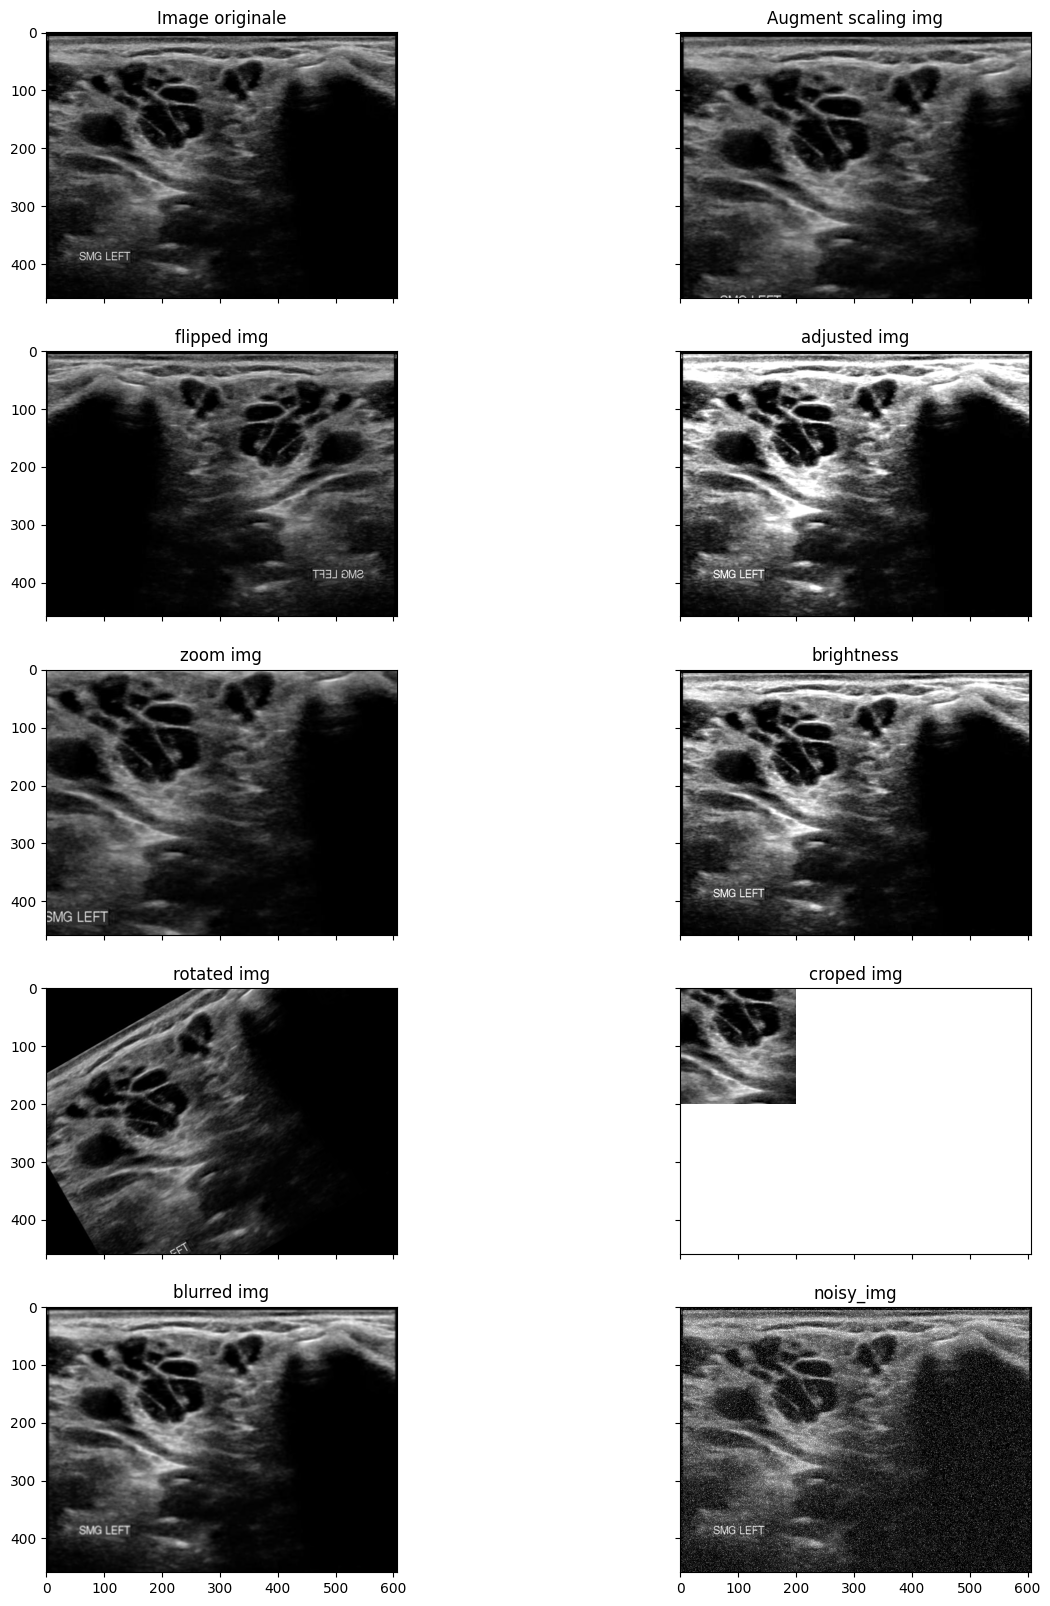

In [ ]:
# Afficher l'image 
fig, ax = plt.subplots(5,2, sharex=True, sharey=True,figsize=(15,20))
ax[0,0].imshow(img, cmap='gray')
ax[0,0].set_title('Image originale')
ax[0,1].imshow(scale_img, cmap='gray')
ax[0,1].set_title('Augment scaling img')
ax[1,0].imshow(flipped_img, cmap='gray')
ax[1,0].set_title("flipped img")
ax[1,1].imshow(adjusted_img, cmap='gray')
ax[1,1].set_title('adjusted img')
ax[2,0].imshow(zoom_img, cmap='gray')
ax[2,0].set_title('zoom img')
ax[2,1].imshow(lum_img, cmap='gray')
ax[2,1].set_title('brightness')
ax[3,0].imshow(rotated_img, cmap='gray')
ax[3,0].set_title('rotated img')
ax[3,1].imshow(cropped_img, cmap='gray')
ax[3,1].set_title("croped img")
ax[4,0].imshow(blurred_img, cmap='gray')
ax[4,0].set_title("blurred img")
ax[4,1].imshow(noisy_img, cmap='gray')
ax[4,1].set_title('noisy_img')
plt.show()

# TEST Data augmentation

In [ ]:

# Boucle sur les fichiers du dossier, triés par ordre alphabétique
for file_name in sorted(os.listdir(communResized_path)):
        # Ouverture de l'image
        image = Image.open(os.path.join(communResized_path, file_name))
        # Convertir l'image en niveau de gris
        image = image.convert('L')
        # Appliquer une augmentation de luminosité
        img = augment_brightness(image, 1.5)
        # Enregistrer l'image avec un nouveau nom
        new_filename = f"{os.path.splitext(file_name)[0]}_brightness.jpg"
        img.save(os.path.join(augmented_path, new_filename))

In [ ]:
# Boucle sur les fichiers du dossier, triés par ordre alphabétique
for file_name in sorted(os.listdir(communResized_path)):
        # Ouverture de l'image
        image = Image.open(os.path.join(communResized_path, file_name))
        # Convertir l'image en niveau de gris
        image = image.convert('L')
        # Appliquer une augmentation avec effet mirroir
        img = flip_image(image,1)
        # Enregistrer l'image avec un nouveau nom
        new_filename = f"{os.path.splitext(file_name)[0]}_flipped.jpg"
        img.save(os.path.join(augmented_path, new_filename))

In [ ]:
# Boucle sur les fichiers du dossier, triés par ordre alphabétique
for file_name in sorted(os.listdir(communResized_path)):
        # Ouverture de l'image
        image = Image.open(os.path.join(communResized_path, file_name))
        # Convertir l'image en niveau de gris
        image = image.convert('L')
        # Appliquer une augmentation avec effet mirroir
        img = augment_zooming(image,0.8)
        # Enregistrer l'image avec un nouveau nom
        new_filename = f"{os.path.splitext(file_name)[0]}_zoom.jpg"
        img.save(os.path.join(augmented_path, new_filename))

In [ ]:
# Boucle sur les fichiers du dossier, triés par ordre alphabétique
for file_name in sorted(os.listdir(communResized_path)):
        # Ouverture de l'image
        image = Image.open(os.path.join(communResized_path, file_name))
        # Convertir l'image en niveau de gris
        image = image.convert('L')
        # Appliquer une augmentation avec effet mirroir
        img = augment_scaling(image,1.2)
        # Enregistrer l'image avec un nouveau nom
        new_filename = f"{os.path.splitext(file_name)[0]}_scaling.jpg"
        #img.save(os.path.join(augmented_path, new_filename))

In [ ]:
# Boucle sur les fichiers du dossier, triés par ordre alphabétique
for file_name in sorted(os.listdir(communResized_path)):
        # Ouverture de l'image
        image = Image.open(os.path.join(communResized_path, file_name))
     
        img.save(os.path.join(augmented_path, file_name))